<a href="https://colab.research.google.com/github/EllisWebb/UWITFDN-110-A07/blob/main/DATA_5100_Multiclass_Image_Classification_2_Kaggle_Intel_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification

Code for this example comes from [Chapter 1](https://colab.research.google.com/github/fastai/fastbook/blob/master/01_intro.ipynb#scrollTo=51rjRXOLDugq) of
Deep Learning for Coders with fastai & PyTorch by Jeremy Howard and Sylvain Gugger.

## Set up

### Change the runtime

Change the Runtime to utilize the NVIDIA T4 GPU, if it is not already set to the GPU.

In the menu above click
Runtime $\rightarrow$ Change runtime type and change Hardware accelerator to T4 GPU

### Import the `fastai` library

Import all items from `fastai.vision.all`

In [2]:
from fastai.vision.all import *

Import all items from `fastcore.all`

In [3]:
from fastcore.all import *

## Domain problem

We want to develop a model to classify the type of natural scene shown in an image.


## Analytic approach

At this stage of the data science methodology we aim to convert the domain problem into a data problem.

The analytic approach can take different forms depending on the goals:


1.  Descriptive approach: Describe the data using summary statistics and visualizations.
2.  Diagnostic approach: Use statistical analyses to test hypotheses and make inferences about relationships in the data.
3.  Predictive approach: Use models to predict trends outside the range of the data.
4.  Prescriptive approach: Use data to make recommendations for actions.



We will take a predictive approach in this problem. We will train a classifier that can predict the type of natural scene in an image from the following six categories:

'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5

## Natural scene classifier

The data are from the [Kaggle Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification) competition.




Download the images from Kaggle. You can also download the files here using a link to the images that I downloaded.

In [4]:
!wget -O intel-image-classification.zip https://www.dropbox.com/scl/fi/u761krgi7z2ryk5qb9yt6/intel-image-classification.zip?rlkey=3elttczt6q418ib07gm78jwth&dl=0

--2025-10-30 20:16:49--  https://www.dropbox.com/scl/fi/u761krgi7z2ryk5qb9yt6/intel-image-classification.zip?rlkey=3elttczt6q418ib07gm78jwth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6033:18::a27d:5312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7f80b34051391eeb991cff5526.dl.dropboxusercontent.com/cd/0/inline/C0NTNuCfPtdpc8DWuP4vKi-ers2fCJ3V34YJIYQ5HOSBbfnX_Tse6sH5l7GUyOLdduvMqEOj9nz68k1rQUc9qPO0CNdijslKo85Jh4TWBZhseQCWbbCJdg9V8XGnTS3iWAE/file# [following]
--2025-10-30 20:16:50--  https://uc7f80b34051391eeb991cff5526.dl.dropboxusercontent.com/cd/0/inline/C0NTNuCfPtdpc8DWuP4vKi-ers2fCJ3V34YJIYQ5HOSBbfnX_Tse6sH5l7GUyOLdduvMqEOj9nz68k1rQUc9qPO0CNdijslKo85Jh4TWBZhseQCWbbCJdg9V8XGnTS3iWAE/file
Resolving uc7f80b34051391eeb991cff5526.dl.dropboxusercontent.com (uc7f80b34051391eeb991cff5526.dl.dropboxusercontent.com)... 162.125.2.15, 2620:100:601b:15::a27d:80f
Co

Unzip the data file

In [5]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

Note that the images are organized into three folders, seg_train, seg_test, and seg_pred that contain the images for training, testing, and prediction, respectively.

In [6]:
!ls

intel-image-classification.zip	sample_data  seg_pred  seg_test  seg_train


Look at a few images

In [7]:
file_names = get_image_files('seg_train/seg_train')

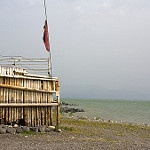

In [8]:
# select an example image
img = PILImage.create(file_names[100]) # Change the number here to pick a different image

# plot the image
img.to_thumb(192)

## Data processing

In contrast to the pets examples, the image labels in this problem will be derived from the folders in which we find the images.

Processing of the images (input) and annotations (output) will be done at the same time as we set up the neural network model that we will use to perform image classification. The neural network will require a particular image size for all input images, so we will need to resize the images.

### Process the images

Load the image data used to train and test the network.

In this problem we will load the data using `ImageDataLoaders.from_folder` because our images are organized into folders.

As with the `DataBlock`, the `ImageDataLoaders` will allow us to
describe how the data should be loaded and transformed.

In [9]:
path = '/content'

dls = ImageDataLoaders.from_folder(path,
                            train = 'seg_train',
                            valid = 'seg_test',
                            item_tfms = Resize(450, pad_mode='zeros'),
                            batch_tfms=[*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)],
                            bs=32) # default is 64, local can run out of memory when used with densenet201

## Exploratory data analysis

Our exploratory data analysis consists of examining example images. We can use the `show_batch()` method to show a few images and their labels.


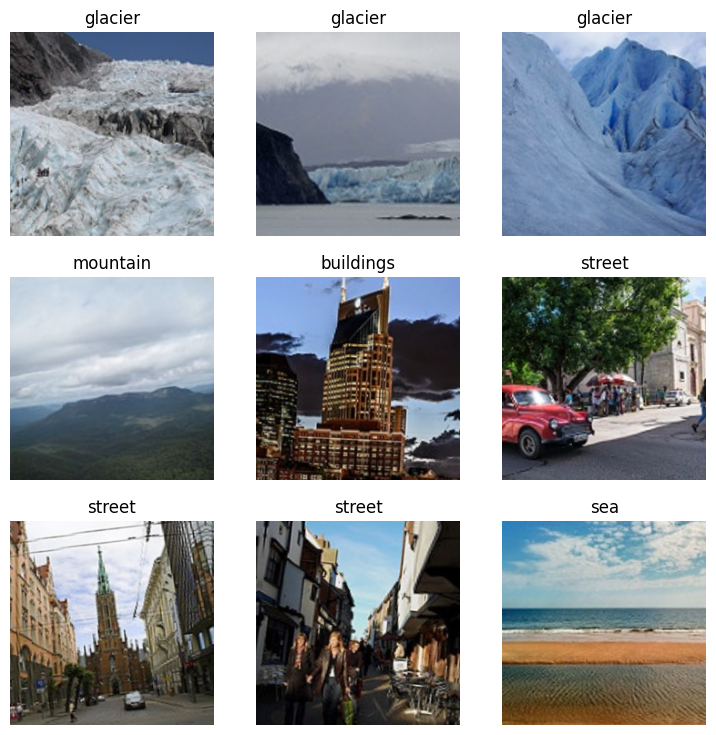

In [10]:
dls.show_batch()

## Modeling

We will use a deep neural network to build the classification model. Rather than training a network from scratch, we will modify an existing deep neural network to solve the problem of recognizing dogs vs. cats.

The model will be based on the ResNet-34 deep neural network that was trained on the [ImageNet](https://www.image-net.org/) dataset.

![picture](https://storage.googleapis.com/kaggle-datasets-images/6978/10038/d9e74a548a8cdca167b38520ac8bf405/data-original.png?t=2017-12-13-20-32-53)

The ImageNet data set consists of images of many types.

We will use transfer learning to train the network to classify images as dogs and cats.


### Train and test the model

We will train a model to classify the breed of dogs or cats, starting from the resnet34 model that has already been trained to solve an image classification problem involing many types of images.

fast.ai's `vision_learner` makes this very easy to perform. We create a `vision_learner` object by specifying 3 things: (1) the data block created above `dls`, (2) the name of the neural network we want to use as the basis for the model `resnet34`, and (3) the metric we want to use to evaluate the performance of the model `error_rate`.

We can then fine tune the weights of the model to perform our specific task by minimizing the error for a specified number of epochs.

In [11]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 119MB/s]


In [ ]:
learn.fine_tune(epochs=1)

epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time


We see that the error rate is small on the validation image set.

### Assess model performance

fast.ai has a `ClassificationInterpretation` function to help analyze the performance of the model.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

Plot the confusion matrix, which shows the number of images in the validation set that were correctly and incorrectly classified by the model.

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6))

Showing the top loss images allows us to see where the model made the largest mistakes by having a high probability that the image was of one class when it was actually a different type of natural scene.

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))

## Deployment

We can use the model to predict the animal type for an example image and plot the class probabilities.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
img = PILImage.create(file_names[3])
prediction, _, probs = learn.predict(img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Display the image in the first subplot
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title(f"Prediction: {prediction}")

# Display the bar plot in the second subplot
sns.barplot(x=probs, y=dls.vocab, orient='h', ax=axes[1])
axes[1].set_xlabel("Probability")
axes[1].set_ylabel("Class Label")
axes[1].set_title("Prediction Probabilities")

plt.tight_layout()
plt.show()

We are doing this for one of our images, but you can apply the model to other images. Let's see what it predicts for a picture of [Mt Rainier](https://en.wikipedia.org/wiki/Mount_Rainier#/media/File:Rainier20200906.jpg) from Wikipedia

![picture](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Rainier20200906.jpg/1280px-Rainier20200906.jpg)



In [ ]:
# Download the image
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Rainier20200906.jpg/1280px-Rainier20200906.jpg -O Rainier20200906.jpg

# create the image
img = PILImage.create('Rainier20200906.jpg')

# plot the image
img.to_thumb(192)

In [ ]:
prediction, _, probs = learn.predict(img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the image in the first subplot
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title(f"Prediction: {prediction}")

# Display the bar plot in the second subplot
sns.barplot(x=probs, y=dls.vocab, orient='h', ax=axes[1])
axes[1].set_xlabel("Probability")
axes[1].set_ylabel("Class Label")
axes[1].set_title("Prediction Probabilities")

plt.tight_layout()
plt.show()

## Evaluation

Do we fully understand how the model is classifying the images? Are you confident that the model will be robust?
